In [1]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from joblib import dump, load
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import numpy as np
import itertools

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
stops = set(stopwords.words("english"))
def cleantext(string):
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)
    tx = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [5]:
train = pd.read_csv('original_data/original_train.csv')
val = pd.read_csv('original_data/original_val.csv')

In [6]:
train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
#test['tweet'] = test['tweet'].map(lambda x: cleantext(x))

In [7]:
def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))



SVM
val:
[[ 963   57]
 [  83 1037]]
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      1020
        real       0.95      0.93      0.94      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.94      0.93      2140
weighted avg       0.93      0.93      0.93      2140

Accuracy :  0.9345794392523364
Precison :  0.9348008619335585
Recall :  0.9345794392523364
F1 :  0.9345519215989282


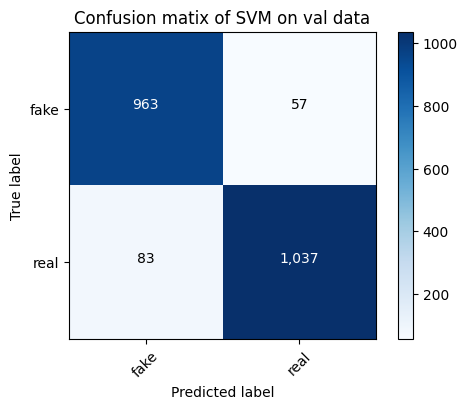

In [8]:
# Original experiment in LinearSVC() with default parameters
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', LinearSVC())
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('SVM')
print ('val:')
pred=pipeline.predict(val['tweet'])
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

val_ori = pd.read_csv('original_data/original_train.csv')
val_ori_reset = val_ori.iloc[:len(pred)]
pred_reindexed = pred[val_ori_reset.index]
svm_val_misclass_df = val_ori_reset[pred_reindexed != val['label']]


SVM
val:
[[ 964   56]
 [  83 1037]]
              precision    recall  f1-score   support

        fake       0.92      0.95      0.93      1020
        real       0.95      0.93      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.93      0.94      0.93      2140
weighted avg       0.94      0.94      0.94      2140

Accuracy :  0.9350467289719626
Precison :  0.9352890373439096
Recall :  0.9350467289719626
F1 :  0.93501874136537


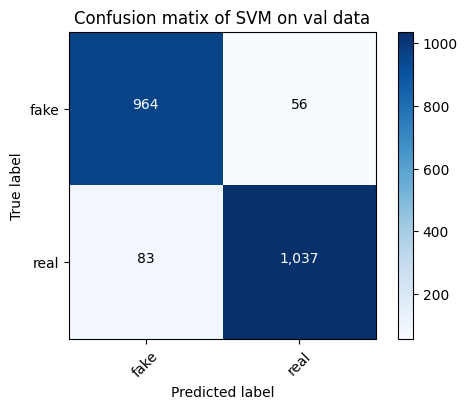

In [9]:
# Carried out the experiments in finding the best hyperparameter of LinearSVC() to modify the model
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', LinearSVC(C=0.9))
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('SVM')
print ('val:')
pred=pipeline.predict(val['tweet'])
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

Logistic Regression
val:
[[ 959   61]
 [  94 1026]]
              precision    recall  f1-score   support

        fake       0.91      0.94      0.93      1020
        real       0.94      0.92      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140

Accuracy :  0.927570093457944
Precison :  0.9279421090866252
Recall :  0.927570093457944
F1 :  0.9275350904769529


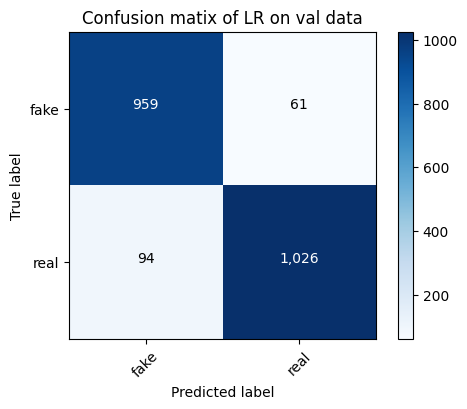

In [10]:
# Original experiment in LogisticRegression() with default parameters
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', LogisticRegression())
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('Logistic Regression')
print ('val:')
pred=pipeline.predict(val['tweet'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on val data')


Logistic Regression
val:
[[ 961   59]
 [  86 1034]]
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      1020
        real       0.95      0.92      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140

Accuracy :  0.9322429906542056
Precison :  0.9324819857849682
Recall :  0.9322429906542056
F1 :  0.9322137949494866


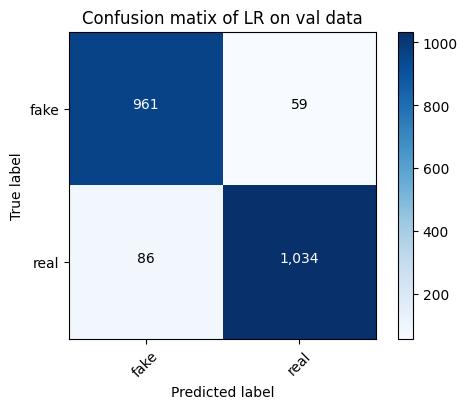

In [11]:
# Carried out the experiments in finding the best hyperparameter of LogisticRegression() to modify the model
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', LogisticRegression(C=10, solver='liblinear'))
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('Logistic Regression')
print ('val:')
pred=pipeline.predict(val['tweet'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on val data')

Gradient Boost
val:
[[921  99]
 [180 940]]
              precision    recall  f1-score   support

        fake       0.84      0.90      0.87      1020
        real       0.90      0.84      0.87      1120

    accuracy                           0.87      2140
   macro avg       0.87      0.87      0.87      2140
weighted avg       0.87      0.87      0.87      2140

Accuracy :  0.8696261682242991
Precison :  0.8720355572135395
Recall :  0.8696261682242991
F1 :  0.8695823519205196


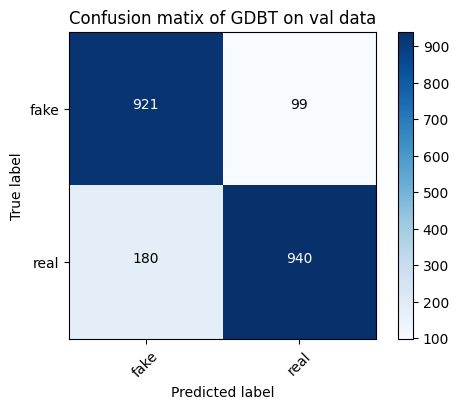

In [12]:
# Original experiment in GradientBoostingClassifier() with default parameters
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', GradientBoostingClassifier())
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('Gradient Boost')
print ('val:')
pred=pipeline.predict(val['tweet'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of GDBT on val data')




Gradient Boost
val:
[[ 944   76]
 [ 118 1002]]
              precision    recall  f1-score   support

        fake       0.89      0.93      0.91      1020
        real       0.93      0.89      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Accuracy :  0.9093457943925234
Precison :  0.9099512094557449
Recall :  0.9093457943925234
F1 :  0.9092975377805698


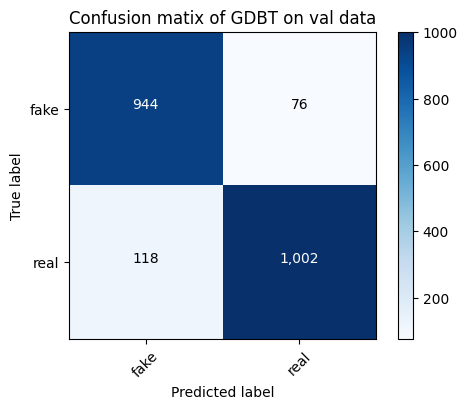

In [13]:
# Carried out the experiments in finding the best hyperparameter of GradientBoostingClassifier() to modify the model
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', GradientBoostingClassifier(learning_rate=0.5, n_estimators=200, subsample=0.8, min_samples_split=10, max_depth=7))
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('Gradient Boost')
print ('val:')
pred=pipeline.predict(val['tweet'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of GDBT on val data')

Decision Tree
val:
[[841 179]
 [137 983]]
              precision    recall  f1-score   support

        fake       0.86      0.82      0.84      1020
        real       0.85      0.88      0.86      1120

    accuracy                           0.85      2140
   macro avg       0.85      0.85      0.85      2140
weighted avg       0.85      0.85      0.85      2140

Accuracy :  0.8523364485981308
Precison :  0.8533799477735019
Recall :  0.8523364485981308
F1 :  0.8525296008697187


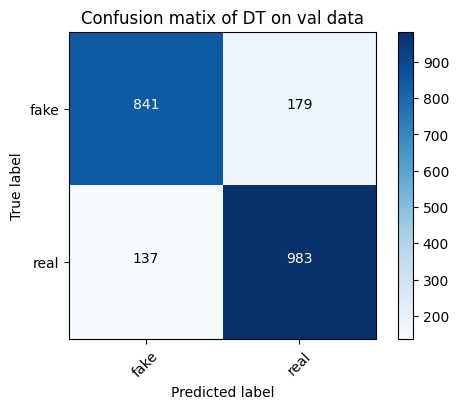

In [14]:
# Original experiment in tree.DecisionTreeClassifier() with default parameters
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', tree.DecisionTreeClassifier())
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('Decision Tree')
print ('val:')
pred=pipeline.predict(val['tweet'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of DT on val data')




Decision Tree
val:
[[863 157]
 [139 981]]
              precision    recall  f1-score   support

        fake       0.86      0.85      0.85      1020
        real       0.86      0.88      0.87      1120

    accuracy                           0.86      2140
   macro avg       0.86      0.86      0.86      2140
weighted avg       0.86      0.86      0.86      2140

Accuracy :  0.8616822429906542
Precison :  0.8619330185345166
Recall :  0.8616822429906542
F1 :  0.8617465898509851


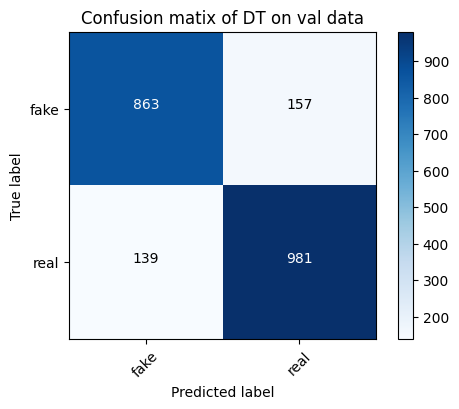

In [15]:
# Carried out the experiments in finding the best hyperparameter of DecisionTreeClassifier() to modify the model
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', tree.DecisionTreeClassifier(criterion='entropy',min_samples_split=5))
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('Decision Tree')
print ('val:')
pred=pipeline.predict(val['tweet'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of DT on val data')


In [ ]:
svm_val_misclass_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 1 to 2138
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      140 non-null    int64 
 1   tweet   140 non-null    object
 2   label   140 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.4+ KB


In [ ]:
svm_val_misclass_df.to_excel('svm_val_misclassified.xlsx')